In [14]:
import os
import time
import torch
import torchvision
import requests
import zipfile
import numpy as np
from torch import nn
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
class configs:
    device='cpu'
    train_folder='data/train/'
    test_folder='data/test/'

conf=configs()

In [ ]:
with open('data/images.zip','wb') as f:
    request=requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    f.write(request.content)

In [3]:
class ImageDatasets(Dataset):

    def __init__(
        self,
        directory,
        transforms=None,
    ):
        self.paths=[]
        for sub_dir in os.listdir(directory):
            currentDir=directory+f'{sub_dir}/'
            for image in os.listdir(currentDir):
                self.paths.append((currentDir+image,sub_dir))

        self.classes=os.listdir(directory)
        self.class_to_idx={c:i for i,c in enumerate(self.classes)}
        self.idx_to_class={i:c for c,i in self.class_to_idx.items()}
        self.transforms=transforms


    def load_image(
        self,
        idx,
    ) -> Image.Image:
        image_path=self.paths[idx][0]
        return Image.open(image_path)

    
    def __len__(self):
        return len(self.paths)


    def __getitem__(
        self,
        idx,
    ):
        img=self.load_image(idx)
        class_name=self.paths[idx][1]
        class_idx=self.class_to_idx[class_name]

        if self.transforms:
            return self.transforms(img), class_idx
        else:
            return img, class_idx
        

class VGGMock(nn.Module):
    def __init__(self, num_classes=3):
        super(VGGMock, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((8,8))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x


def seeAnImage(dataset):
    random_selected=np.random.choice(len(dataset))
    img, _class = dataset[random_selected]

    plt.imshow(img.permute(1,2,0))
    plt.title(f'{dataset.idx_to_class[_class]}')
    plt.show()

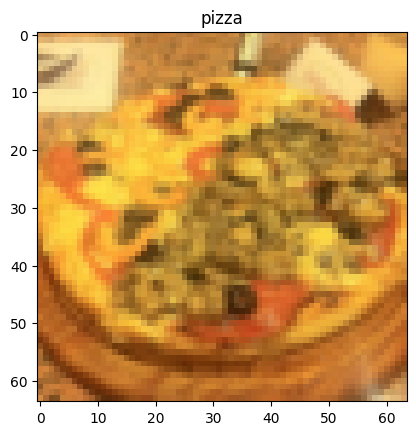

In [4]:
transformation_list=[
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
]
trainDataset=ImageDatasets(conf.train_folder, transforms.Compose(transformation_list))
trainDataLoader=DataLoader(trainDataset, batch_size=16, shuffle=True)
seeAnImage(trainDataset)

transformation_list.pop(1)
testDataset=ImageDatasets(conf.test_folder, transforms.Compose(transformation_list))
testDataLoader=DataLoader(testDataset, batch_size=16, shuffle=False)

In [7]:
class vggTrainingInfer:

    def __init__(
        self,
        model,
        loss_fn,
        optimizer,
        device=conf.device,
    ):
        self.model=model
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.device=device


    def _step(
        self,
        dataLoader,
        infer=False,
    ):
        if infer:
            self.model.eval()
        else:
            self.model.train()

        currentLoss, currentMetric=0, 0
        for batch, (X,y) in enumerate(dataLoader):
            X,y=X.to(self.device), y.to(self.device)
            y_pred=self.model(X)
            loss=self.loss_fn(y_pred, y)
            currentLoss += loss.item()

            if not infer:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            y_pred_output=torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            currentMetric+=(y_pred_output==y).sum().item()/len(y_pred)

        currentLoss=currentLoss/len(dataLoader)
        currentMetric=currentMetric/len(dataLoader)
        return currentLoss, currentMetric

    
    def fullStep(
        self,
        train_dataloader,
        test_dataloader,
        epochs,
    ):
        results={
            'train_loss':[],
            'train_metric':[],
            'eval_loss':[],
            'eval_metric':[],
        }
        for epoch in tqdm(range(epochs), total=epochs):
            train_loss, train_acc=self._step(
                train_dataloader,
            )

            test_loss, test_acc=self._step(
                test_dataloader,
                infer=True,
            )
            print(f"Epoch: {epoch} | train loss: {train_loss} | train_acc: {train_acc}")
            print(f"test loss: {test_loss} | test_acc: {test_acc}")
            results['train_loss'].append(train_loss)
            results['train_metric'].append(train_acc)
            results['eval_loss'].append(test_loss)
            results['eval_metric'].append(test_acc)
        return results

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model=VGGMock()
model.to(conf.device)
optimizer=torch.optim.Adam(model.parameters(),lr=5e-4)
loss_fn=torch.nn.CrossEntropyLoss()

vggTrainer=vggTrainingInfer(
    model,
    loss_fn,
    optimizer, 
)
start_time=time.time()
vggTrainer.fullStep(
    trainDataLoader,
    testDataLoader,
    epochs=16
)
end_time=time.time()
print(f'total training time: {end_time-start_time:.3f} secs')

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0 | train loss: 1.1028931379318236 | train_acc: 0.30416666666666664
test loss: 1.105552077293396 | test_acc: 0.3875
Epoch: 1 | train loss: 1.0941704352696737 | train_acc: 0.42083333333333334
test loss: 1.092600154876709 | test_acc: 0.4
Epoch: 2 | train loss: 1.084268609682719 | train_acc: 0.45
test loss: 1.0784810543060304 | test_acc: 0.45
Epoch: 3 | train loss: 1.0780109286308288 | train_acc: 0.45
test loss: 1.0952315092086793 | test_acc: 0.35568181818181815
Epoch: 4 | train loss: 1.0118692795435587 | train_acc: 0.49583333333333335
test loss: 1.05716632604599 | test_acc: 0.42272727272727273
Epoch: 5 | train loss: 0.9455998986959457 | train_acc: 0.5125
test loss: 0.990666127204895 | test_acc: 0.4284090909090909
Epoch: 6 | train loss: 0.9166670560836792 | train_acc: 0.5458333333333333
test loss: 0.9988495707511902 | test_acc: 0.4727272727272728
Epoch: 7 | train loss: 0.9757274707158407 | train_acc: 0.49166666666666664
test loss: 0.9918458342552186 | test_acc: 0.48522727272727273


In [9]:
custom_image_path='data/eval/04-pizza-dad.jpeg'

with open(custom_image_path,'wb') as f:
    request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    print(f'downloading {custom_image_path}...')
    f.write(request.content)

downloading data/eval/04-pizza-dad.jpeg...


In [19]:
opModel=vggTrainer.model

custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255.
custom_image_transform=transforms.Compose(
    [transforms.Resize([64,64])]
)
custom_image_transformed=custom_image_transform(custom_image)
opModel.eval()
with torch.inference_mode():
  custom_image_pred=opModel(custom_image_transformed.unsqueeze(0))

trainDataset.classes[custom_image_pred.argmax(dim=-1).item()]

'pizza'